In [112]:
subj = "Subj1"
exp = "exp_pca"

n_stages = [ 9, 8, 10 ][int(subj[-1:]) - 1]
scale = (exp != "reproduction")
scale = True

### Imports

In [113]:
%load_ext autoreload
%autoreload 2

import os

import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import mne
import tqdm
import numpy
import pandas

pandas.set_option("display.precision", 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [114]:
data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif")
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")
df_features = pandas.read_feather(f"{subj}/{exp}/features.feather")
features = df_features.to_numpy()
print('Features: ', features.shape)

Opening raw data file Subj1/src/data_rr_filt-raw.fif...


    Range : 3500 ... 471000 =      7.000 ...   942.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj1\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
Features:  (1046, 15)


In [115]:
if subj == "Subj2": # m8 (artifacts at the end)
    epochs = epochs[:-2]
    if exp != "reproduction": features = features[:-2]

### SDA

In [116]:
result, df_st_edges = SDA.SDA(scale = scale).apply(features)

Applying to 1046 samples with 15 features each
Running stage 1


  0%|          | 0/589 [00:00<?, ?it/s]

Running stage 2


  0%|          | 0/672 [00:00<?, ?it/s]

In [117]:
if exp != "reproduction":
    edges_true = numpy.loadtxt(f"{subj}/reproduction/internal/best_edges.txt").astype(numpy.int32)
    print(edges_true)

    metrics = [ ]
    for row in  tqdm.tqdm(result['St_edges']):
        metrics.append(SDA.clustquality.cluster_metrics_ground(edges_true, row))
    result = pandas.concat([ result, pandas.DataFrame(metrics) ], axis = 1)

[   0   39  282  492  560  682  784  857  976 1046]


100%|██████████| 2016/2016 [00:06<00:00, 322.22it/s]


In [118]:
result.to_csv(f"{subj}/{exp}/result.csv")
df_st_edges.to_csv(f"{subj}/{exp}/df_st_edges.csv")

### Analysis

In [119]:
def analyze(result: pandas.DataFrame, key: str, folder: str):
    if not os.path.exists(f"{subj}/{exp}/{folder}"):
        os.makedirs(f"{subj}/{exp}/{folder}")

    results = SDA.analytics.best_results(result, key = key)
    results.to_csv(f"{subj}/{exp}/{folder}/results.csv")
    display(results)
    
    best_result = SDA.analytics.best_result(result, key = key, n_stages = n_stages)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{subj}/{exp}/{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{subj}/{exp}/{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    edge_statistics = SDA.analytics.edge_statistics(features, best_edges)
    edge_statistics.to_csv(f"{subj}/{exp}/{folder}/edge_statistics.csv")
    display(edge_statistics)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{subj}/{exp}/{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_stats(features, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/stats.svg")
    SDA.analytics.plot_features(df_features, best_edges).savefig(f"{subj}/{exp}/{folder}/features.svg")
    SDA.analytics.plot_eeg_stages(data, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/eeg_stages.svg")

#### Internal

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
42,20,35,20,3,Median,"[0, 104, 681, 1046]",1082.16,2.78,2.97e-02,114.58,5.87,0.16,106.69,4.72,0.52,0.27,0.49
1,0,35,10,4,Mode,"[0, 244, 681, 842, 1046]",1107.23,2.71,3.16e-02,110.36,10.23,0.15,116.76,2.29,0.69,0.49,0.63
52,20,40,20,5,Mode,"[0, 38, 244, 681, 842, 1046]",784.87,3.02,2.52e-02,106.16,8.48,0.18,88.49,2.08,0.73,0.52,0.64
16,0,40,20,6,Mode,"[0, 38, 244, 566, 681, 842, 1046]",710.21,3.12,6.53e-03,98.14,3.93,0.19,84.94,1.86,0.80,0.66,0.73
16,0,40,20,7,Mode,"[0, 38, 244, 566, 681, 842, 976, 1046]",685.68,3.18,6.88e-03,90.85,5.23,0.20,81.18,1.78,0.84,0.71,0.77
52,20,40,20,8,Mode,"[0, 38, 244, 493, 566, 681, 842, 976, 1046]",557.55,2.90,-1.54e-03,80.72,5.18,0.18,66.18,2.07,0.88,0.81,0.84
52,20,40,20,9,Mode,"[0, 38, 104, 244, 493, 566, 681, 842, 976, 1046]",399.72,2.57,-2.14e-02,74.44,5.05,0.15,48.27,2.23,0.86,0.74,0.77
52,20,40,20,10,Mode,"[0, 38, 104, 199, 244, 493, 566, 681, 842, 976...",323.10,2.49,-2.49e-02,68.23,4.82,0.14,38.91,2.27,0.84,0.70,0.74
49,20,40,15,11,Mode,"[0, 39, 104, 199, 244, 493, 566, 609, 681, 842...",264.74,2.44,-4.26e-02,62.62,4.93,0.13,32.02,2.25,0.83,0.67,0.72
15,0,40,20,12,Median,"[0, 38, 104, 199, 244, 345, 493, 566, 681, 780...",229.76,2.21,-4.63e-02,58.17,5.21,0.12,28.54,2.80,0.86,0.69,0.74


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,20,40,20,9,Mode,"[0, 38, 104, 244, 493, 566, 681, 842, 976, 1046]",399.72,2.57,-0.02,74.44,5.05,0.15,48.27,2.23,0.86,0.74,0.77


array([   0,   38,  104,  244,  493,  566,  681,  842,  976, 1046])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.31,65.82,1.09,51905.96,46.39
1,0.11,40.20,1.79,39034.68,29.50
2,0.23,134.00,1.44,116644.84,36.08
3,0.07,10.28,4.09,8025.69,11.92
4,0.12,29.12,2.15,20286.20,21.31
5,0.20,80.83,1.56,57213.52,29.20
6,0.16,42.21,2.22,38202.03,22.86
7,0.10,12.51,3.12,12625.77,16.57


,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 41.9)","(42.7, 101.1)","(101.9, 228.3)","(229.1, 456.3)","(457.1, 517.9)","(518.7, 619.5)","(620.3, 758.7)","(759.5, 877.1)","(877.9, 938.7)"
"Time length, sec",32.0,58.4,126.4,227.2,60.8,100.8,138.4,117.6,60.8
Number of epochs,38,66,140,249,73,115,161,134,70


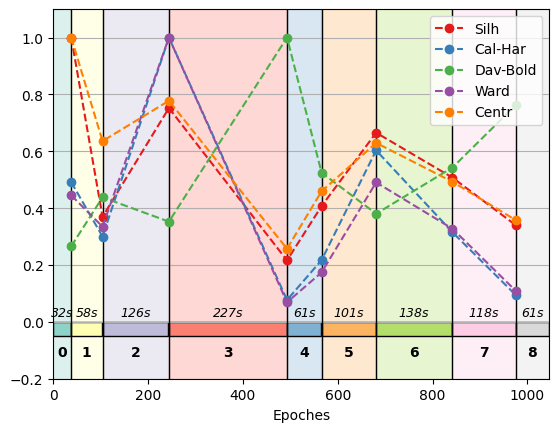

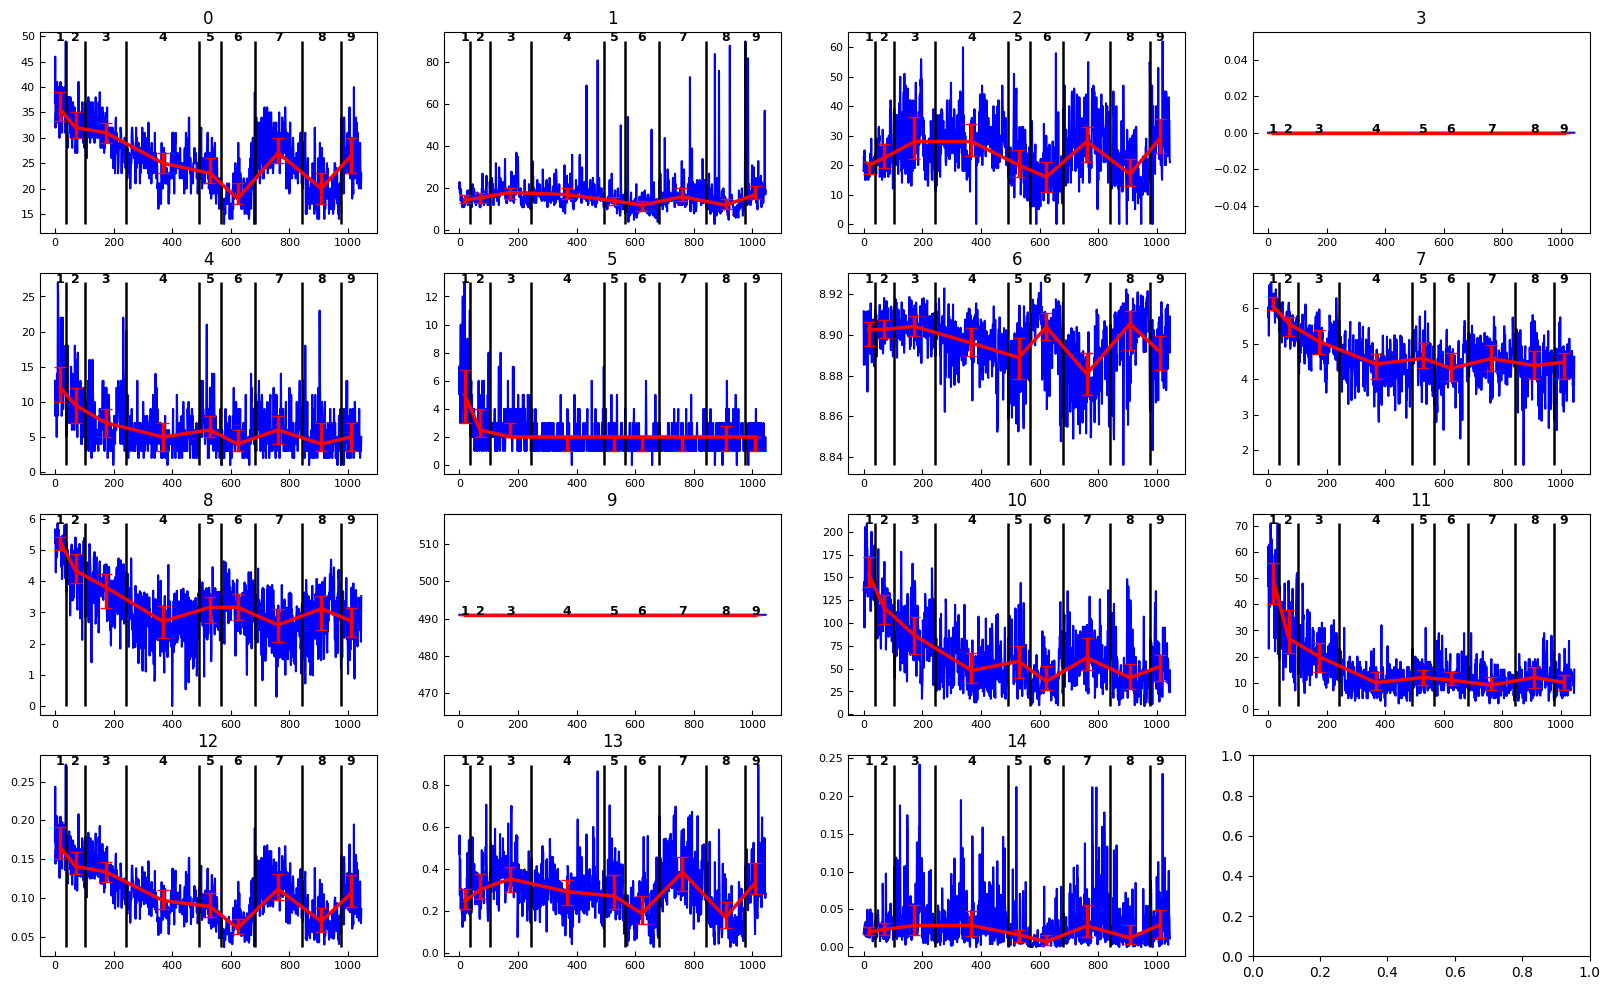

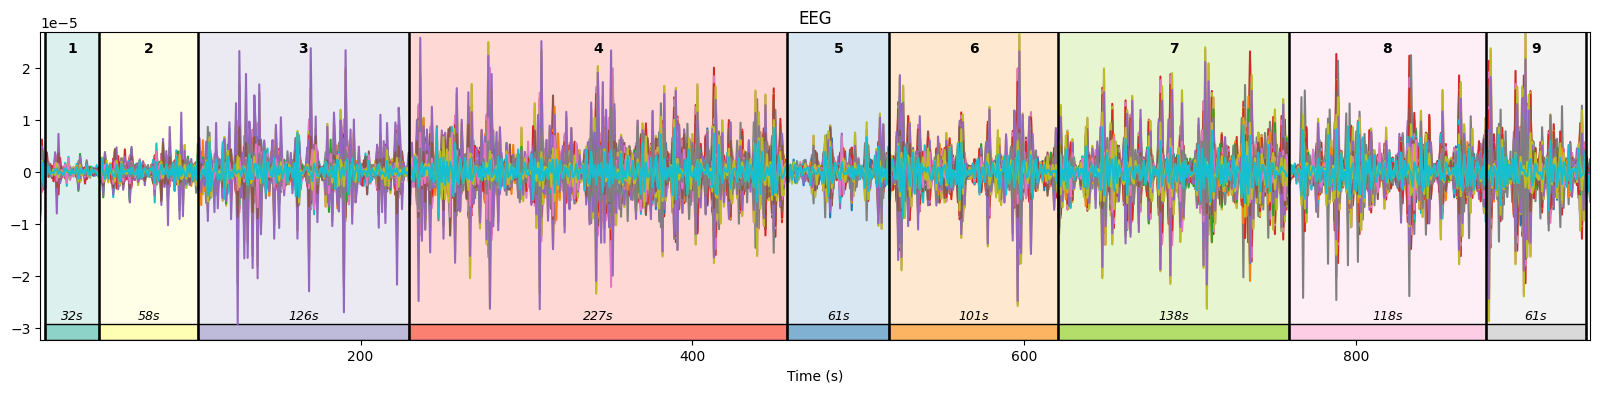

In [120]:
analyze(result, 'Avg-Silh', "internal")
# [   0   39  282  492  560  682  784  857  976 1046]

![Alternative Text][1707850881559]

[1707850881559]: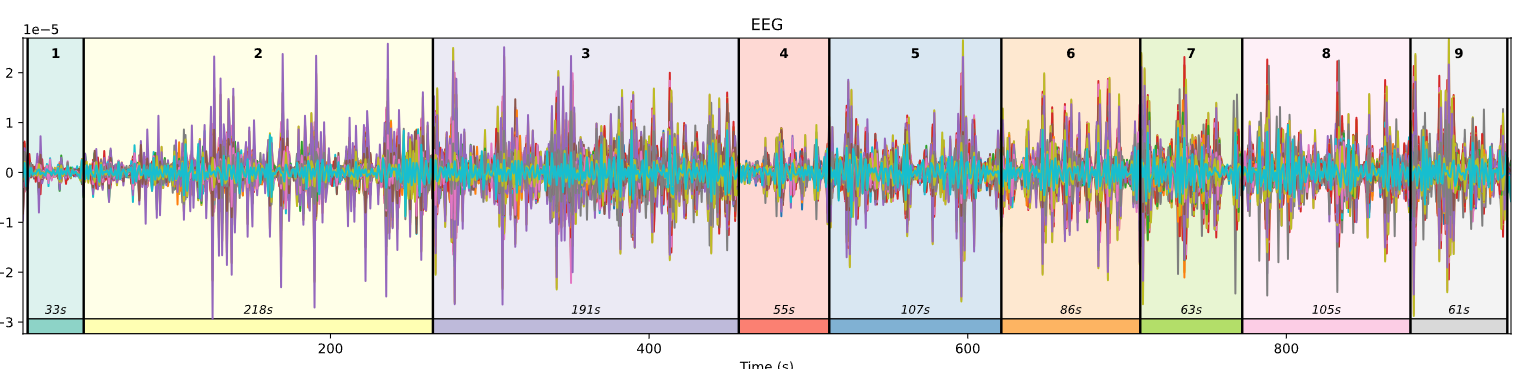

#### External

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
43,20,35,20,3,Mode,"[0, 244, 681, 1046]",1259.43,2.32,5.27e-02,136.83,5.99,0.14,131.62,4.81,0.62,0.40,0.58
10,0,40,10,4,Mode,"[0, 244, 566, 842, 1046]",686.49,1.74,2.47e-02,93.55,6.62,0.10,72.51,5.81,0.71,0.55,0.66
115,60,35,20,5,Mode,"[0, 244, 554, 681, 842, 1046]",898.88,2.90,1.28e-02,98.58,4.27,0.17,102.87,1.95,0.77,0.64,0.72
1,0,35,10,6,Mode,"[0, 39, 244, 566, 681, 842, 1046]",707.81,3.10,6.09e-03,98.06,3.93,0.19,84.65,1.87,0.80,0.67,0.73
33,0,50,20,7,Median,"[0, 39, 244, 543, 681, 842, 976, 1046]",674.83,3.11,9.31e-03,91.10,5.78,0.20,79.92,1.81,0.84,0.73,0.78
49,20,40,15,8,Mode,"[0, 39, 244, 493, 566, 681, 842, 976, 1046]",555.91,2.89,-1.94e-03,80.66,5.18,0.18,65.98,2.07,0.89,0.81,0.84
54,20,45,10,9,Median,"[0, 39, 244, 345, 493, 566, 682, 842, 975, 1046]",411.02,2.58,-2.74e-02,71.24,5.30,0.15,47.88,2.49,0.87,0.77,0.80
52,20,40,20,10,Mode,"[0, 38, 104, 199, 244, 493, 566, 681, 842, 976...",323.10,2.49,-2.49e-02,68.23,4.82,0.14,38.91,2.27,0.84,0.70,0.74
7,0,35,20,11,Mode,"[0, 39, 104, 244, 345, 493, 566, 681, 789, 842...",245.57,2.20,-4.52e-02,61.11,5.18,0.12,30.08,2.80,0.86,0.72,0.76
15,0,40,20,12,Median,"[0, 38, 104, 199, 244, 345, 493, 566, 681, 780...",229.76,2.21,-4.63e-02,58.17,5.21,0.12,28.54,2.80,0.86,0.69,0.74


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,20,45,10,9,Median,"[0, 39, 244, 345, 493, 566, 682, 842, 975, 1046]",411.02,2.58,-0.03,71.24,5.3,0.15,47.88,2.49,0.87,0.77,0.8


array([   0,   39,  244,  345,  493,  566,  682,  842,  975, 1046])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.37,129.15,0.84,143045.02,66.07
1,0.18,94.72,1.42,97801.17,38.02
2,0.04,12.33,3.83,8853.44,12.14
3,0.08,16.18,3.04,11923.39,15.62
4,0.12,29.06,2.16,20169.61,21.22
5,0.20,81.26,1.55,57447.57,29.23
6,0.16,41.98,2.22,37986.86,22.87
7,0.10,12.24,3.18,12371.06,16.35


,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 42.7)","(45.1, 228.3)","(229.1, 321.9)","(322.7, 456.3)","(457.1, 517.9)","(518.7, 620.3)","(621.1, 758.7)","(759.5, 876.3)","(877.1, 938.7)"
"Time length, sec",32.8,183.2,92.8,133.6,60.8,101.6,137.6,116.8,61.6
Number of epochs,39,205,101,148,73,116,160,133,71


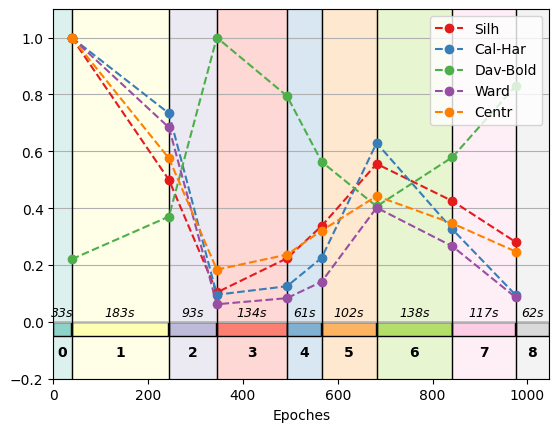

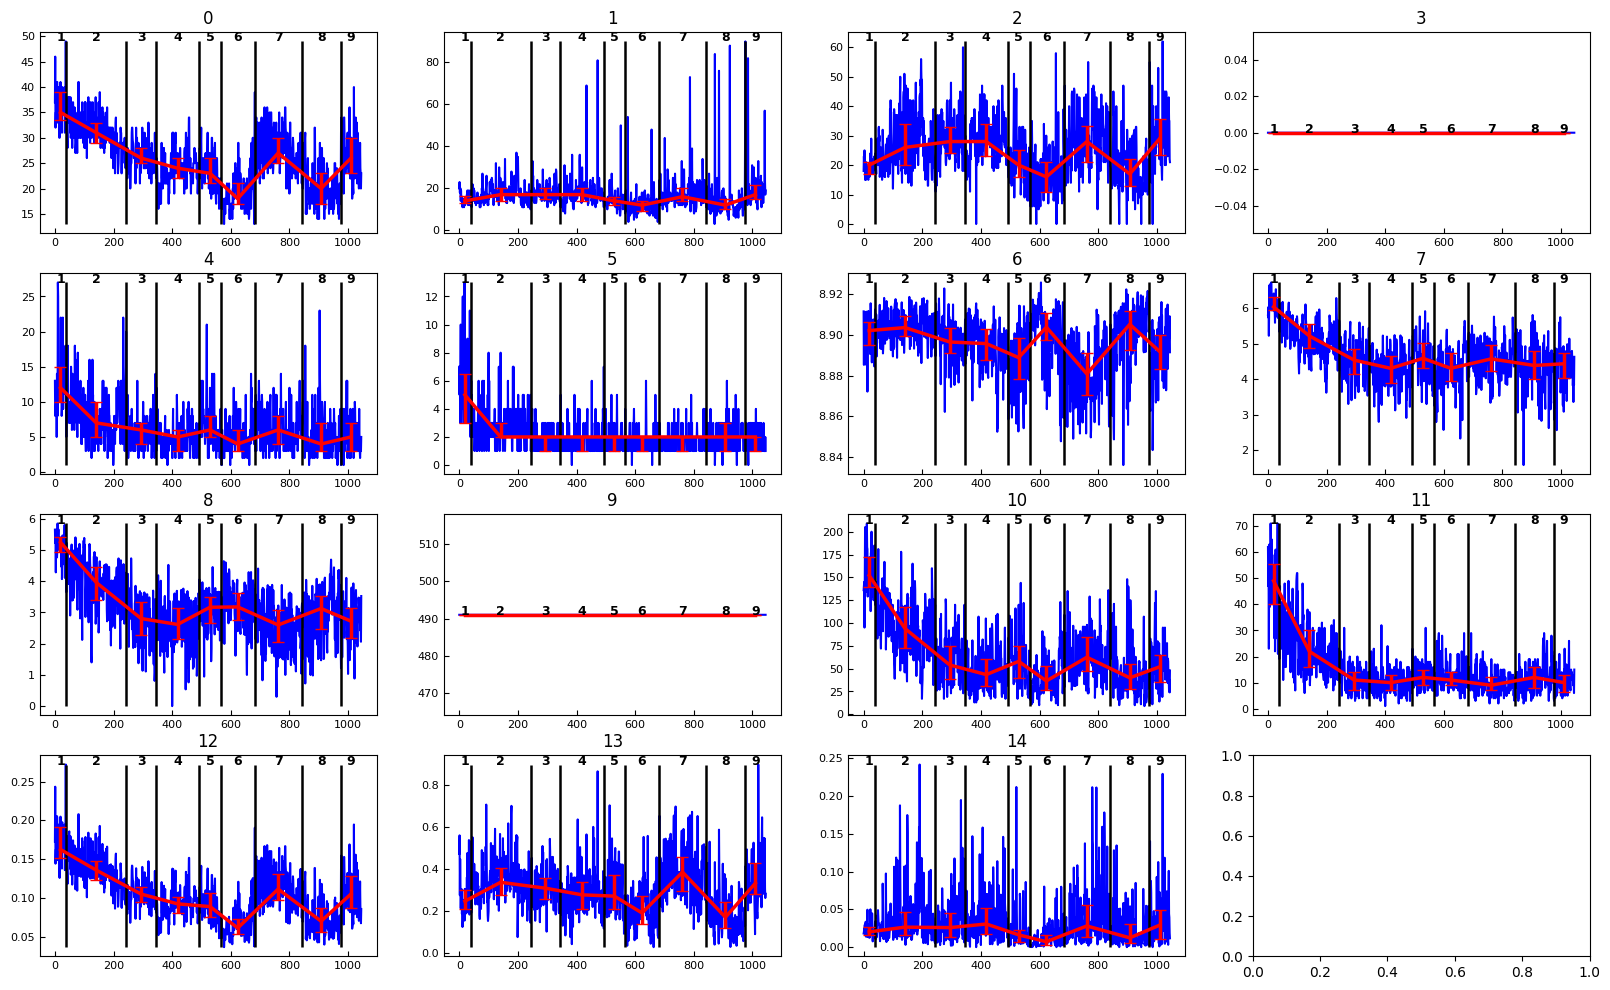

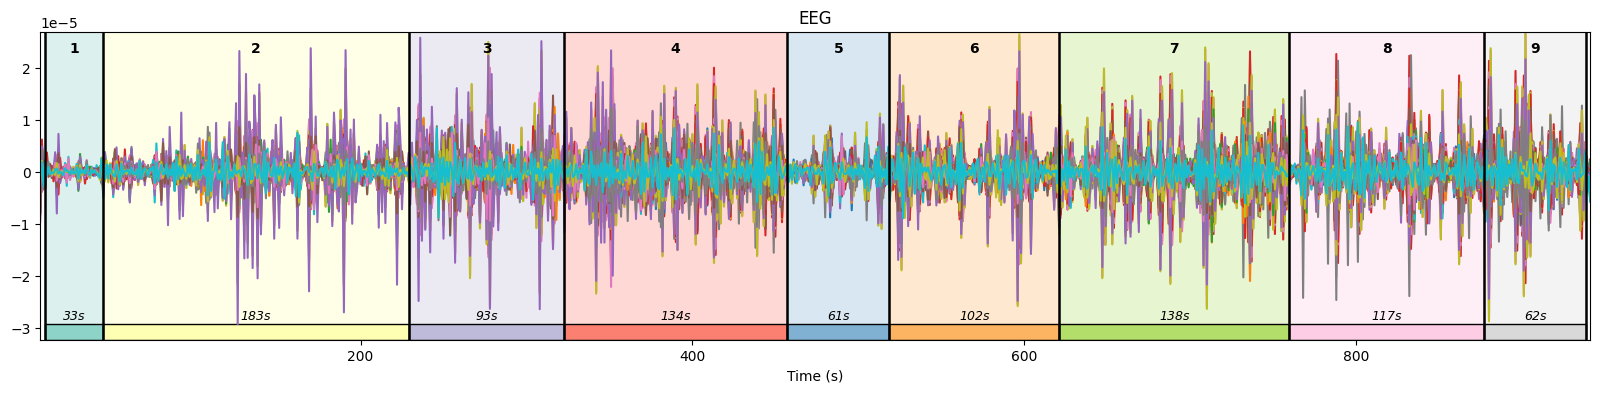

In [121]:
if exp != "reproduction":
    analyze(result, 'FMI', "external")
# [   0   39  282  492  560  682  784  857  976 1046]

![Alternative Text][1707850881559]

[1707850881559]: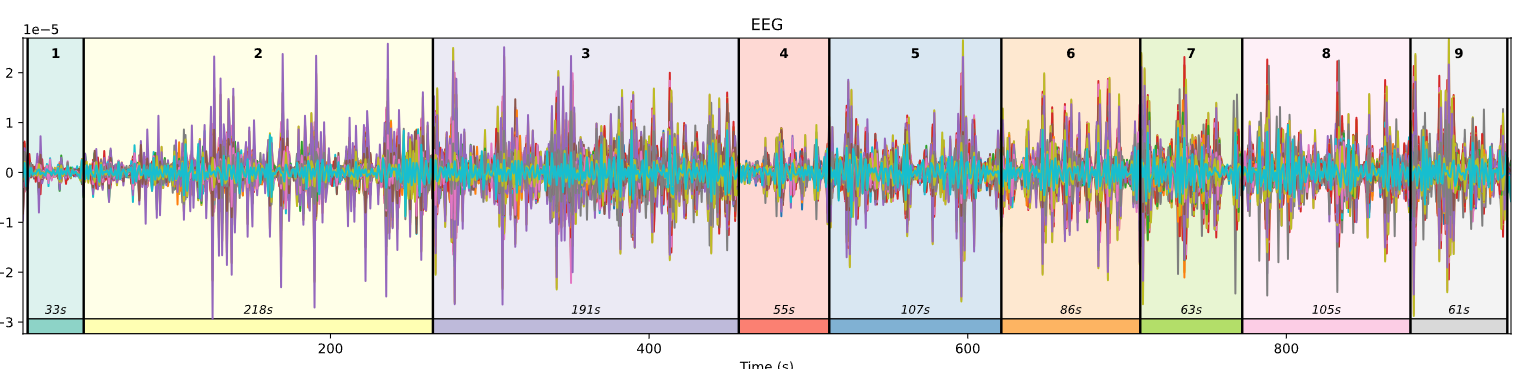